In [106]:
#import library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import blink
from pathlib import Path
from scipy.fft import rfft, rfftfreq
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr


In [107]:
#preparation of data
BASE_LSL = Path(r"C:/Users/yuz/Documents/Test_LOOK/data_lsl/data_exacted")
BASE_TOBII = Path(r"C:/Users/yuz/Documents/Test_LOOK/data_Tobii/data_exacted")

def extract_segments(participant, task):
    psychopy_path = BASE_LSL / participant / f"{participant}_{task.lower()}_psychopy.csv"
    psychopy_df = pd.read_csv(psychopy_path, sep=";", header=None, names=["label", "time"])
    segments = {}
    current_segment = None
    for _, row in psychopy_df.iterrows():
        if pd.isna(row["label"]) or row["label"].strip() == "":
            continue
        label = row["label"].strip()
        time = row["time"]
        if label.lower().endswith("_start"):
            current_segment = label[:-6]  # Remove '_start'
            segments[current_segment] = {"start": time, "end": None}
        elif label.lower().endswith("_end"):
            current_segment = label[:-4]  # Remove '_end'
            if current_segment in segments:
                segments[current_segment]["end"] = time
    segments = {k: v for k, v in segments.items() if v["start"] is not None and v["end"] is not None}
    return segments


In [108]:

# ==== USER PARAMETERS ====
PARTICIPANT = "07_EB"
TASK = "Lecture"
EYE = "right"
# =========================

In [109]:
# Get segment times

# Set PSYCHOPY_TASK according to logic:
if TASK in ["Run", "Run_frame_fixed", "Walk"]:
    PSYCHOPY_TASK = "treadmill"
else:
    PSYCHOPY_TASK = TASK.lower()
segments = extract_segments(PARTICIPANT, PSYCHOPY_TASK)
start_time, end_time = segments[TASK]["start"], segments[TASK]["end"]

# EOG Data (1000 Hz)
eog_file = BASE_LSL / PARTICIPANT / f"{PARTICIPANT}_{PSYCHOPY_TASK.lower()}_EOG.csv"
df_eog = pd.read_csv(eog_file, sep=";", names=["EOG", "time"])
df_eog_segment = df_eog[(df_eog["time"] >= start_time) & (df_eog["time"] <= end_time)]
eog_signal = df_eog_segment["EOG"].to_numpy()
eog_time = np.arange(len(eog_signal)) / 1000  

# Tobii Data (1200 Hz)
tobii_file = BASE_TOBII / PARTICIPANT / f"{PARTICIPANT}_{TASK}.tsv"
df_tobii = pd.read_csv(tobii_file, sep="\t")
eye_openness_signal = df_tobii[f"{EYE}_eye_openness_diameter"].to_numpy()
eye_time = np.arange(len(eye_openness_signal)) / 1200 

# Blink Detection by Tobii
settings = blink.Settings()
settings.Fs = 1200
bd = blink.BlinkDetector(settings)

df_eo, _ = bd.blink_detector_eo(eye_time, eye_openness_signal, settings.Fs,
                                filter_length=settings.filter_length,
                                gap_dur=settings.gap_dur,
                                width_of_blink=settings.width_of_blink,
                                min_separation=settings.min_separation)

blink_peaks_time = df_eo["time_peak"].to_numpy()
peak_idx = np.searchsorted(eye_time, blink_peaks_time)

c:\Users\yuz\Documents\Test_LOOK\BlinkDetector-main\BlinkDetector-main\blink.py:445: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.openness_at_peak[df.openness_at_peak < 0] = 0


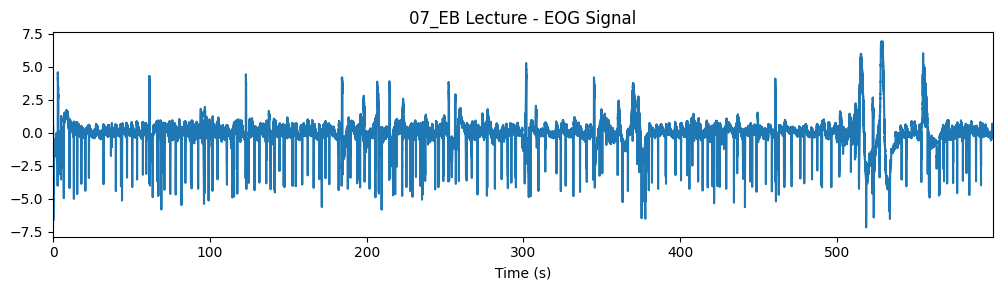

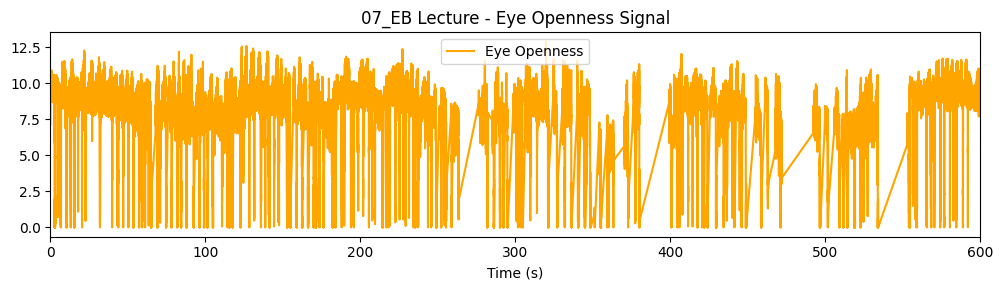

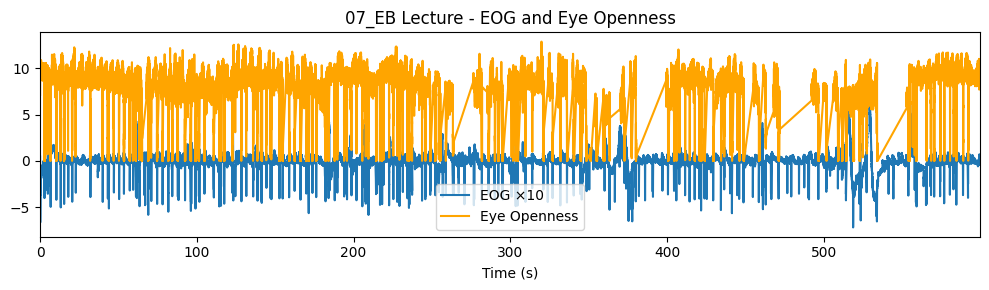

In [110]:
# Plot EOG
plt.figure(figsize=(10, 3))
plt.plot(eog_time, eog_signal * 10, label="EOG ×10", color="tab:blue")
plt.xlabel("Time (s)")
plt.title(f"{PARTICIPANT} {TASK} - EOG Signal")
plt.xlim(eog_time.min(), eog_time.max())
plt.tight_layout()
plt.show()

# Plot Eye Openness
plt.figure(figsize=(10, 3))
plt.plot(eye_time, eye_openness_signal, label="Eye Openness", color="orange")
plt.xlabel("Time (s)")
plt.title(f"{PARTICIPANT} {TASK} - Eye Openness Signal")
plt.legend()
plt.xlim(eye_time.min(), eye_time.max())
plt.tight_layout()
plt.show()

# Plot Both Together
plt.figure(figsize=(10, 3))
plt.plot(eog_time, eog_signal * 10, label="EOG ×10", color="tab:blue")
plt.plot(eye_time, eye_openness_signal, label="Eye Openness", color="orange")
plt.xlabel("Time (s)")
plt.title(f"{PARTICIPANT} {TASK} - EOG and Eye Openness")
plt.legend()
plt.xlim(min(eog_time.min(), eye_time.min()), min(eog_time.max(), eye_time.max()))
plt.tight_layout()
plt.show()


In [111]:
#FFT
# --- FFT for EOG signal ---
fs_eog = 1000 
N_eog = len(eog_signal)
yf_eog = np.abs(rfft(eog_signal - np.mean(eog_signal)))
xf_eog = rfftfreq(N_eog, 1 / fs_eog)

# --- FFT for Eye Openness signal ---
fs_openness = 1200
N_open = len(eye_openness_signal)
yf_open = np.abs(rfft(eye_openness_signal - np.mean(eye_openness_signal)))
xf_open = rfftfreq(N_open, 1 / fs_openness)

In [112]:
#apply filter
#filter function
def bandpass_filter(data, fs, lowcut, highcut, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)
def lowpass_filter(data, fs, cutoff, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Apply lowpass filter: 
eog_signal_filt = lowpass_filter(eog_signal, fs=1000, cutoff=5)
eye_openness_signal_filt = lowpass_filter(eye_openness_signal, fs=1200, cutoff=5)



In [113]:
# ----- Adjustable blink detection parameters -----
# Eye Openness
max_blink_amplitude_openness = 7
min_blink_width_ms_openness = 1
max_blink_width_ms_openness = 1500      # (ms)
prominence_openness=0.5

# EOG
min_blink_amplitude_eog = 0.05    
min_blink_width_ms_eog = 5           
max_blink_width_ms_eog =  2000       
prominence_eog = 0.001           
 
min_interval=1500
EOG_POLARITY = 'negative'


width_samples_openness = int(np.round(min_blink_width_ms_openness / 1000 * 1200))
openness_thresh = max_blink_amplitude_openness
min_width_samples_eog = int(np.round(min_blink_width_ms_eog / 1000 * 1000))
max_width_samples_eog = int(np.round(max_blink_width_ms_eog / 1000 * 1000))


In [114]:
# ---- Blink detection  ----
def remove_close_blinks_keep_median(blink_times, blink_values, min_interval_ms):
    """
    Remove blinks that occur within min_interval_ms (ms), keeping only the median blink in each group.
    """
    if len(blink_times) == 0:
        return blink_times, blink_values

    idx_sort = np.argsort(blink_times)
    times = np.array(blink_times)[idx_sort]
    values = np.array(blink_values)[idx_sort]

    keep_idx = []
    group = [0] 

    for i in range(1, len(times)):
        if (times[i] - times[i-1]) * 1000 < min_interval_ms:
            group.append(i)
        else:
            median_i = group[len(group)//2]
            keep_idx.append(median_i)
            group = [i]

    if group:
        median_i = group[len(group)//2]
        keep_idx.append(median_i)

    keep_idx = np.array(keep_idx)
    return times[keep_idx], values[keep_idx]


# ---- Find blinks in filtered Eye Openness ----
peaks_openness, props_open = find_peaks(
    -eye_openness_signal_filt,
    height=-openness_thresh,
    distance=width_samples_openness,
    width=(min_blink_width_ms_openness, max_blink_width_ms_openness),
    prominence=prominence_openness
)
blink_peak_time_openness = eye_time[peaks_openness]
blink_peaks_y_openness = eye_openness_signal_filt[peaks_openness]

# ---- Find blinks in filtered EOG ----
if EOG_POLARITY == 'negative':
    eog_for_peaks = -eog_signal_filt
    height_eog = abs(min_blink_amplitude_eog)
else:
    eog_for_peaks = eog_signal_filt
    height_eog = min_blink_amplitude_eog

peaks_eog, props_eog = find_peaks(
    eog_for_peaks,
    height=height_eog,
    distance=min_width_samples_eog,
    width=(min_width_samples_eog, max_width_samples_eog),
    prominence=prominence_eog   
)
blink_peaks_time_eog = eog_time[peaks_eog]
blink_peaks_y_eog = eog_signal_filt[peaks_eog]

# ---- Remove closely spaced blinks (keep only median in each group) ----
blink_peak_time_openness, blink_peaks_y_openness = remove_close_blinks_keep_median(
    blink_peak_time_openness, blink_peaks_y_openness, min_interval_ms=min_interval
)
blink_peaks_time_eog, blink_peaks_y_eog = remove_close_blinks_keep_median(
    blink_peaks_time_eog, blink_peaks_y_eog, min_interval_ms=min_interval
)

# ---- Calculate difference for each filtered EOG blink to nearest filtered Eye Openness blink ----
blink_time_diffs = []
for t_eog in blink_peaks_time_eog:
    if len(blink_peak_time_openness) == 0:
        diff = np.nan
    else:
        diff = t_eog - blink_peak_time_openness[np.argmin(np.abs(blink_peak_time_openness - t_eog))]
    blink_time_diffs.append(diff)

# ---- Calculate durations in minutes for blink rate ----
segment_duration_min = (end_time - start_time) / 60.0

# ---- Calculate blink rates ----
eog_blink_rate = len(blink_peaks_time_eog) / segment_duration_min if segment_duration_min > 0 else np.nan
tobii_blink_rate = len(blink_peak_time_openness) / segment_duration_min if segment_duration_min > 0 else np.nan

print(f"EOG blink rate detected: {eog_blink_rate:.2f} per min, \n"
      f"Tobii blink rate detected: {tobii_blink_rate:.2f} per min")

EOG blink rate detected: 14.50 per min, 
Tobii blink rate detected: 13.30 per min


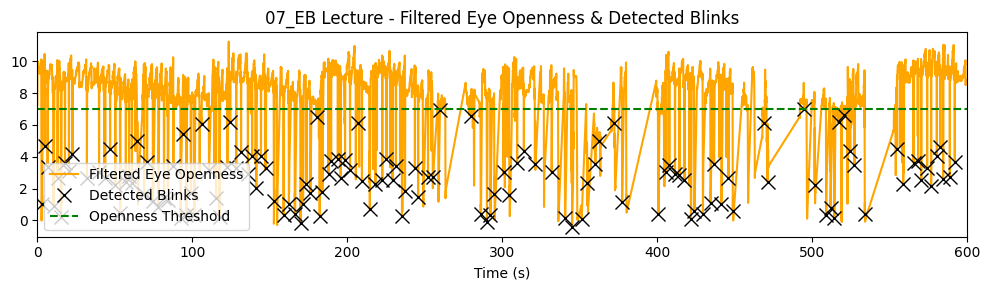

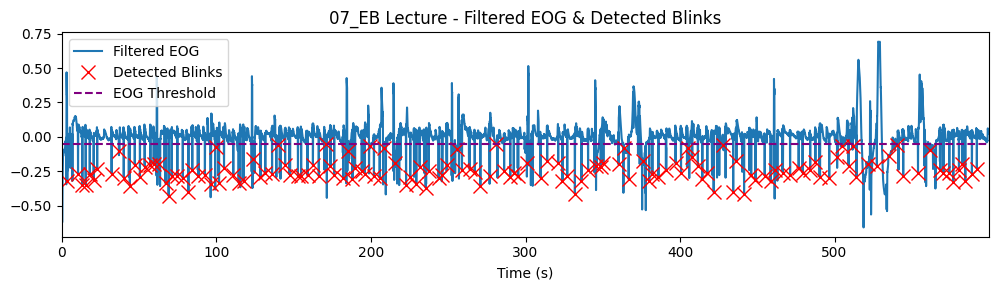

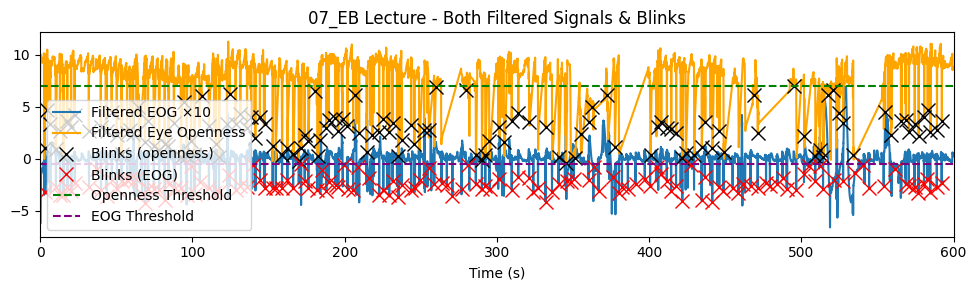

In [115]:
# Plot Eye Openness with threshold
plt.figure(figsize=(10, 3))
plt.plot(eye_time, eye_openness_signal_filt, label="Filtered Eye Openness", color="orange")
plt.plot(blink_peak_time_openness, blink_peaks_y_openness, "kx", ms=10, lw=2, label="Detected Blinks")
plt.axhline(y=openness_thresh, color="green", linestyle="--", label="Openness Threshold")  # Add Tobii threshold line
plt.xlabel("Time (s)")
plt.title(f"{PARTICIPANT} {TASK} - Filtered Eye Openness & Detected Blinks")
plt.legend()
plt.xlim(eye_time.min(), eye_time.max())
plt.tight_layout()
plt.show()

# Plot EOG with threshold
plt.figure(figsize=(10, 3))
plt.plot(eog_time, eog_signal_filt, label="Filtered EOG", color="tab:blue")
plt.plot(blink_peaks_time_eog, blink_peaks_y_eog, "rx", ms=10, lw=2, label="Detected Blinks")
if EOG_POLARITY == 'negative':
    plt.axhline(y=-abs(min_blink_amplitude_eog), color="purple", linestyle="--", label="EOG Threshold")
else:
    plt.axhline(y=min_blink_amplitude_eog, color="purple", linestyle="--", label="EOG Threshold")
plt.xlabel("Time (s)")
plt.title(f"{PARTICIPANT} {TASK} - Filtered EOG & Detected Blinks")
plt.legend()
plt.xlim(eog_time.min(), eog_time.max())
plt.tight_layout()
plt.show()

# Plot both signals with thresholds
plt.figure(figsize=(10, 3))
plt.plot(eog_time, eog_signal_filt * 10, label="Filtered EOG ×10", color="tab:blue")
plt.plot(eye_time, eye_openness_signal_filt, label="Filtered Eye Openness", color="orange")
plt.plot(blink_peak_time_openness, blink_peaks_y_openness, "kx", ms=10, lw=2, label="Blinks (openness)")
plt.plot(blink_peaks_time_eog, blink_peaks_y_eog * 10, "rx", ms=10, lw=2, label="Blinks (EOG)")
plt.axhline(y=openness_thresh, color="green", linestyle="--", label="Openness Threshold")
if EOG_POLARITY == 'negative':
    plt.axhline(y=-abs(min_blink_amplitude_eog) * 10, color="purple", linestyle="--", label="EOG Threshold")
else:
    plt.axhline(y=min_blink_amplitude_eog * 10, color="purple", linestyle="--", label="EOG Threshold")
plt.xlabel("Time (s)")
plt.title(f"{PARTICIPANT} {TASK} - Both Filtered Signals & Blinks")
plt.legend()
plt.xlim(min(eog_time.min(), eye_time.min()), max(eog_time.max(), eye_time.max()))
plt.tight_layout()
plt.show()


In [116]:
# --- Calculate difference and apply translation ---
blink_time_diffs = []
for t_eog in blink_peaks_time_eog:
    if len(blink_peak_time_openness) == 0:
        diff = np.nan
    else:
        diff = t_eog - blink_peak_time_openness[np.argmin(np.abs(blink_peak_time_openness - t_eog))]
    blink_time_diffs.append(diff)



# --- Compute blink rates and average delta t ---
segment_duration_min = (end_time - start_time) / 60.0
eog_blink_rate = len(blink_peaks_time_eog) / segment_duration_min if segment_duration_min > 0 else np.nan
tobii_blink_rate = len(blink_peak_time_openness) / segment_duration_min if segment_duration_min > 0 else np.nan
delta_t = np.array(blink_time_diffs)
delta_t = delta_t[~np.isnan(delta_t)]


# Define a Gaussian weight: higher for values near 0
sigma = 0.1  # adjust sigma as needed; 0.1 gives more weight to values close to 0
weights = np.exp(-0.5 * (delta_t / sigma) ** 2)


# Weighted average |delta t|
if np.sum(weights) > 0:
    avg_delta_t_weighted = np.sum(np.abs(delta_t) * weights) / np.sum(weights)
else:
    avg_delta_t_weighted = np.nan


    
    # --- Apply translation (e.g., shift EyeOpenness blinks by +0.08s) ---
translation_value = avg_delta_t_weighted # seconds (positive shifts blinks later in time)
translated_blink_peaks_time_openness = blink_peak_time_openness + translation_value

# --- Recalculate difference for each EOG blink (filtered, translated openness) ---
translated_blink_time_diffs = []
for t_eog in blink_peaks_time_eog:
    if len(translated_blink_peaks_time_openness) == 0:
        diff = np.nan
    else:
        diff = t_eog - translated_blink_peaks_time_openness[np.argmin(np.abs(translated_blink_peaks_time_openness - t_eog))]
    translated_blink_time_diffs.append(diff)

    delta_t_trans = np.array(translated_blink_time_diffs)
    delta_t_trans = delta_t_trans[~np.isnan(delta_t_trans)]
    weights_trans = np.exp(-0.5 * (delta_t_trans / sigma) ** 2)
if np.sum(weights_trans) > 0:
    avg_delta_t_trans_weighted = np.sum(np.abs(delta_t_trans) * weights_trans) / np.sum(weights_trans)
else:
    avg_delta_t_trans_weighted = np.nan

print(f"EOG blink rate detected: {eog_blink_rate:.2f} per min, \n"
      f"Tobii blink rate detected: {tobii_blink_rate:.2f} per min, \n"
      f"average delta t (weighted): {avg_delta_t_weighted:.3f} s, \n"
      f"average delta t after translation (weighted): {avg_delta_t_trans_weighted:.3f} s")


EOG blink rate detected: 14.50 per min, 
Tobii blink rate detected: 13.30 per min, 
average delta t (weighted): 0.069 s, 
average delta t after translation (weighted): 0.058 s


Completeness Analysis

Linear Regression Results:
  Slope: 5.1314
  Intercept: 3.9648
  R²: 0.0754
  Pearson r: 0.2746 (p = 0.06476)


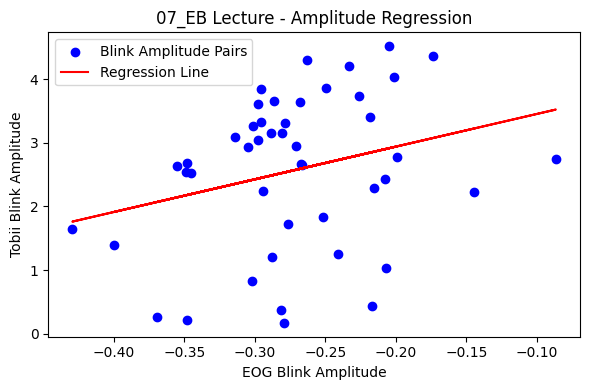

In [117]:
# --- Match EOG and Tobii blink amplitudes at closest times (after translation) ---
matched_eog_amplitudes = []
matched_tobii_amplitudes = []

for t_eog, amp_eog in zip(blink_peaks_time_eog, blink_peaks_y_eog):
    if len(translated_blink_peaks_time_openness) == 0:
        continue
    # Find closest Tobii blink
    idx_closest = np.argmin(np.abs(translated_blink_peaks_time_openness - t_eog))
    t_tobii = translated_blink_peaks_time_openness[idx_closest]
    amp_tobii = blink_peaks_y_openness[idx_closest]
    
    # Only consider if time difference is below threshold (e.g., 100 ms)
    if np.abs(t_tobii - t_eog) < 0.1:
        matched_eog_amplitudes.append(amp_eog)
        matched_tobii_amplitudes.append(amp_tobii)

matched_eog_amplitudes = np.array(matched_eog_amplitudes).reshape(-1, 1)
matched_tobii_amplitudes = np.array(matched_tobii_amplitudes)

# --- Perform Linear Regression and Correlation ---
if len(matched_eog_amplitudes) >= 2:
    reg = LinearRegression()
    reg.fit(matched_eog_amplitudes, matched_tobii_amplitudes)
    pred = reg.predict(matched_eog_amplitudes)
    r2 = r2_score(matched_tobii_amplitudes, pred)

    # Pearson correlation coefficient (r)
    r, p_value = pearsonr(matched_eog_amplitudes.flatten(), matched_tobii_amplitudes)

    print(f"Linear Regression Results:\n"
          f"  Slope: {reg.coef_[0]:.4f}\n"
          f"  Intercept: {reg.intercept_:.4f}\n"
          f"  R²: {r2:.4f}\n"
          f"  Pearson r: {r:.4f} (p = {p_value:.4g})")

    # Plot
    plt.figure(figsize=(6, 4))
    plt.scatter(matched_eog_amplitudes, matched_tobii_amplitudes, color="blue", label="Blink Amplitude Pairs")
    plt.plot(matched_eog_amplitudes, pred, color="red", label="Regression Line")
    plt.xlabel("EOG Blink Amplitude")
    plt.ylabel("Tobii Blink Amplitude")
    plt.title(f"{PARTICIPANT} {TASK} - Amplitude Regression")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Not enough matched blink amplitude pairs for regression.")


In [118]:
partial_percentage = 0.8

PBR (EOG):  0.903448275862069
PBR (Tobii):  0.9774436090225563


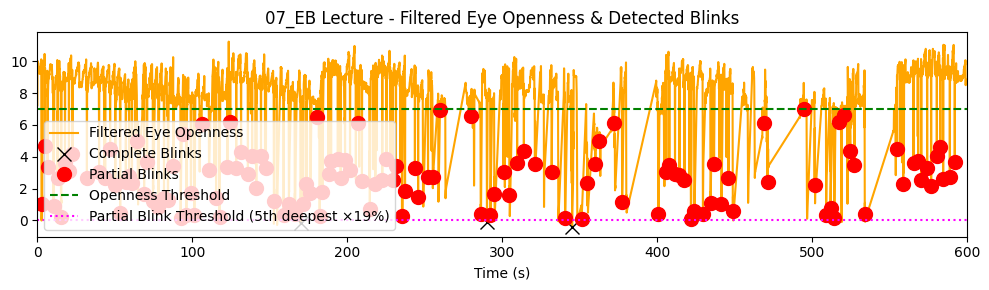

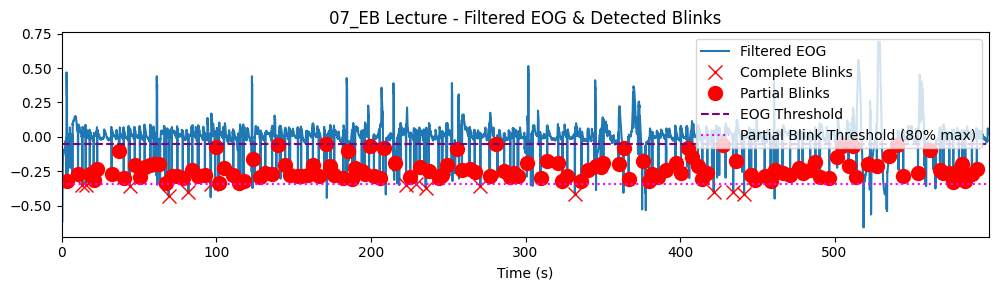

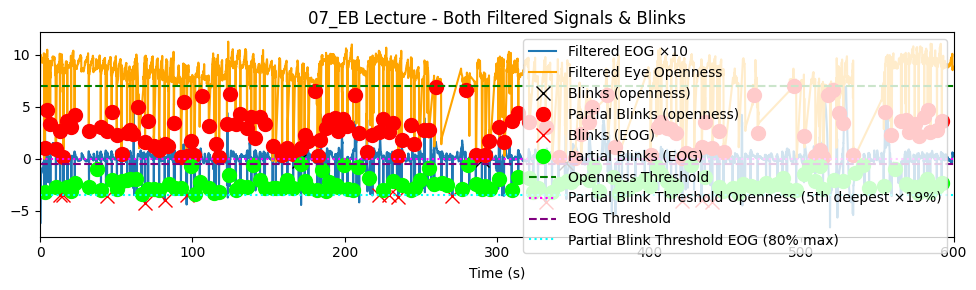

In [119]:

# --- Tobii: threshold from the 5th largest (most closed) blink (lower = more closed) ---
# Sort blink peaks: most closed (lowest) to least (highest)
sorted_peaks = np.sort(blink_peaks_y_openness)
if len(sorted_peaks) >= 5:
    fifth_min = sorted_peaks[4]  # put 4 if desire the 5th smallest, otherwise -1
else:
    fifth_min = sorted_peaks[-1]  # fallback to the deepest available
partial_threshold_openness = (1 - partial_percentage) * fifth_min

# --- EOG: threshold by percentage of max absolute amplitude (as before) ---
if EOG_POLARITY == 'negative':
    partial_threshold_eog = -partial_percentage * np.max(np.abs(blink_peaks_y_eog))
else:
    partial_threshold_eog = partial_percentage * np.max(np.abs(blink_peaks_y_eog))

# --- Find indices of partial blinks
# Tobii: partial if above threshold (i.e., not as closed)
incomplete_idx_openness = np.where(blink_peaks_y_openness > partial_threshold_openness)[0]
complete_idx_openness = np.where(blink_peaks_y_openness <= partial_threshold_openness)[0]

# EOG: logic as before
if EOG_POLARITY == 'negative':
    incomplete_idx_eog = np.where(blink_peaks_y_eog > partial_threshold_eog)[0]
    complete_idx_eog = np.where(blink_peaks_y_eog <= partial_threshold_eog)[0]
else:
    incomplete_idx_eog = np.where(blink_peaks_y_eog < partial_threshold_eog)[0]
    complete_idx_eog = np.where(blink_peaks_y_eog >= partial_threshold_eog)[0]

# Compute segment duration in minutes
segment_duration_min = (end_time - start_time) / 60.0

# Blink rates
eog_blink_rate = len(blink_peaks_time_eog) / segment_duration_min if segment_duration_min > 0 else np.nan
tobii_blink_rate = len(blink_peak_time_openness) / segment_duration_min if segment_duration_min > 0 else np.nan

partial_blink_rate_openness = np.sum(blink_peaks_y_openness > partial_threshold_openness) / len(blink_peaks_y_openness) if len(blink_peaks_y_openness) > 0 else np.nan

if EOG_POLARITY == 'negative':
    partial_blink_rate_eog = np.sum(blink_peaks_y_eog > partial_threshold_eog) / len(blink_peaks_y_eog) if len(blink_peaks_y_eog) > 0 else np.nan
else:
    partial_blink_rate_eog = np.sum(blink_peaks_y_eog < partial_threshold_eog) / len(blink_peaks_y_eog) if len(blink_peaks_y_eog) > 0 else np.nan

print("PBR (EOG): ",partial_blink_rate_eog)
print("PBR (Tobii): ",partial_blink_rate_openness)

# === Eye Openness with thresholds (Tobii) and partial blinks highlighted ===
plt.figure(figsize=(10, 3))
plt.plot(eye_time, eye_openness_signal_filt, label="Filtered Eye Openness", color="orange")
plt.plot(blink_peak_time_openness[complete_idx_openness], blink_peaks_y_openness[complete_idx_openness], "kx", ms=10, lw=2, label="Complete Blinks")
plt.plot(blink_peak_time_openness[incomplete_idx_openness], blink_peaks_y_openness[incomplete_idx_openness], "o", ms=10, color="red", label="Partial Blinks")
plt.axhline(y=openness_thresh, color="green", linestyle="--", label="Openness Threshold")
plt.axhline(y=partial_threshold_openness, color="magenta", linestyle=":", label=f"Partial Blink Threshold (5th deepest ×{int((1-partial_percentage)*100)}%)")
plt.xlabel("Time (s)")
plt.title(f"{PARTICIPANT} {TASK} - Filtered Eye Openness & Detected Blinks")
plt.legend()
plt.xlim(eye_time.min(), eye_time.max())
plt.tight_layout()
plt.show()

# === EOG with thresholds and partial blinks highlighted ===
plt.figure(figsize=(10, 3))
plt.plot(eog_time, eog_signal_filt, label="Filtered EOG", color="tab:blue")
plt.plot(blink_peaks_time_eog[complete_idx_eog], blink_peaks_y_eog[complete_idx_eog], "rx", ms=10, lw=2, label="Complete Blinks")
plt.plot(blink_peaks_time_eog[incomplete_idx_eog], blink_peaks_y_eog[incomplete_idx_eog], "o", ms=10, color="red", label="Partial Blinks")
if EOG_POLARITY == 'negative':
    plt.axhline(y=-abs(min_blink_amplitude_eog), color="purple", linestyle="--", label="EOG Threshold")
else:
    plt.axhline(y=min_blink_amplitude_eog, color="purple", linestyle="--", label="EOG Threshold")
plt.axhline(y=partial_threshold_eog, color="magenta", linestyle=":", label=f"Partial Blink Threshold ({int(partial_percentage*100)}% max)")
plt.xlabel("Time (s)")
plt.title(f"{PARTICIPANT} {TASK} - Filtered EOG & Detected Blinks")
plt.legend()
plt.xlim(eog_time.min(), eog_time.max())
plt.tight_layout()
plt.show()

# === Both signals with all thresholds and partial blinks highlighted ===
plt.figure(figsize=(10, 3))
plt.plot(eog_time, eog_signal_filt * 10, label="Filtered EOG ×10", color="tab:blue")
plt.plot(eye_time, eye_openness_signal_filt, label="Filtered Eye Openness", color="orange")
plt.plot(blink_peak_time_openness[complete_idx_openness], blink_peaks_y_openness[complete_idx_openness], "kx", ms=10, lw=2, label="Blinks (openness)")
plt.plot(blink_peak_time_openness[incomplete_idx_openness], blink_peaks_y_openness[incomplete_idx_openness], "o", ms=10, color="red", label="Partial Blinks (openness)")
plt.plot(blink_peaks_time_eog[complete_idx_eog], blink_peaks_y_eog[complete_idx_eog] * 10, "rx", ms=10, lw=2, label="Blinks (EOG)")
plt.plot(blink_peaks_time_eog[incomplete_idx_eog], blink_peaks_y_eog[incomplete_idx_eog] * 10, "o", ms=10, color="lime", label="Partial Blinks (EOG)")
plt.axhline(y=openness_thresh, color="green", linestyle="--", label="Openness Threshold")
plt.axhline(y=partial_threshold_openness, color="magenta", linestyle=":", label=f"Partial Blink Threshold Openness (5th deepest ×{int((1-partial_percentage)*100)}%)")
if EOG_POLARITY == 'negative':
    plt.axhline(y=-abs(min_blink_amplitude_eog) * 10, color="purple", linestyle="--", label="EOG Threshold")
else:
    plt.axhline(y=min_blink_amplitude_eog * 10, color="purple", linestyle="--", label="EOG Threshold")
plt.axhline(y=partial_threshold_eog * 10, color="cyan", linestyle=":", label=f"Partial Blink Threshold EOG ({int(partial_percentage*100)}% max)")
plt.xlabel("Time (s)")
plt.title(f"{PARTICIPANT} {TASK} - Both Filtered Signals & Blinks")
plt.legend()
plt.xlim(min(eog_time.min(), eye_time.min()), max(eog_time.max(), eye_time.max()))
plt.tight_layout()
plt.show()


In [120]:
#Save result to Excel
summary_file = Path(r"C:/Users/yuz/Documents/Test_LOOK/partial_blink_rate_analysis.xlsx")
task_id = f"{PARTICIPANT}_{TASK}"

# Compose summary row
main_row = {
    "Task_ID": task_id,
    "Blink Rate (EOG)": eog_blink_rate,
    "Blink Rate (Tobii)": tobii_blink_rate,
    "Partial Blink Rate (EOG)": partial_blink_rate_eog,
    "Partial Blink Rate (Tobii)": partial_blink_rate_openness,
}

# Save or append to Excel file
if summary_file.exists():
    df = pd.read_excel(summary_file)
    df = df[df["Task_ID"] != task_id]  # Remove old entry for this participant & task
    df = pd.concat([df, pd.DataFrame([main_row])], ignore_index=True)
else:
    df = pd.DataFrame([main_row])

df.to_excel(summary_file, index=False)
print(f"Summary saved to: {summary_file}")




Summary saved to: C:\Users\yuz\Documents\Test_LOOK\partial_blink_rate_analysis.xlsx
